In [1]:
import os
import warnings
# Only for the notebook as it clutters output
warnings.filterwarnings("ignore")

import altair as alt
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    auc,
    classification_report,
    f1_score,
    precision_score,
    roc_auc_score,
    recall_score,
    roc_curve,
    precision_recall_curve,
    precision_recall_fscore_support,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

# Some util functions
def json_dir(data, data_dir="altairdata"):
    os.makedirs(data_dir, exist_ok=True)
    return alt.pipe(
        data, alt.to_json(filename=data_dir + "/{prefix}-{hash}.{extension}")
    )


def get_prec_recall_auc(y_actual, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_prob)
    # calculate precision-recall AUC
    auc_prec_recall = auc(recall, precision)
    print("Precision-Recall AUC=%.3f" % (auc_prec_recall))

    plt.plot([0, 1], [0.5, 0.5], linestyle="--")
    plt.plot(recall, precision, marker=".")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


alt.data_transformers.register("json_dir", json_dir)
alt.data_transformers.enable("json_dir")
color = sns.color_palette()
plt.style.use("ggplot")


/Users/prasoonshukla/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%load_ext lab_black
%matplotlib inline

# Data exploration

## Read dataset

I will use the types (categorical/numerical) provided in the PDF to read the dataframe with appropriate types. The following types are used:
- Numeric -> `np.float64`
- Categorical -> `str`

This allows us to read numeric categorical variables correctly while keeping `NaN` values intact. This will be helpful later with encoding categorical features. Copying from the PDF and running a simple keyboard macro gives us formatted `dict` of features and types.

In [3]:
feature_types = {
    "default": "categorical",
    "account_amount_added_12_24m": "numeric",
    "account_days_in_dc_12_24m": "numeric",
    "account_days_in_rem_12_24m": "numeric",
    "account_days_in_term_12_24m": "numeric",
    "account_incoming_debt_vs_paid_0_24m": "numeric",
    "account_status": "categorical",
    "account_worst_status_0_3m": "categorical",
    "account_worst_status_12_24m": "categorical",
    "account_worst_status_3_6m": "categorical",
    "account_worst_status_6_12m": "categorical",
    "age": "numeric",
    "avg_payment_span_0_12m": "numeric",
    "avg_payment_span_0_3m": "numeric",
    "merchant_category": "categorical",
    "merchant_group": "categorical",
    "has_paid": "boolean",
    "max_paid_inv_0_12m": "numeric",
    "max_paid_inv_0_24m": "numeric",
    "name_in_email": "categorical",
    "num_active_div_by_paid_inv_0_12m": "numeric",
    "num_active_inv": "numeric",
    "num_arch_dc_0_12m": "numeric",
    "num_arch_dc_12_24m": "numeric",
    "num_arch_ok_0_12m": "numeric",
    "num_arch_ok_12_24m": "numeric",
    "num_arch_rem_0_12m": "numeric",
    "num_arch_written_off_0_12m": "numeric",
    "num_arch_written_off_12_24m": "numeric",
    "num_unpaid_bills": "numeric",
    "status_last_archived_0_24m": "categorical",
    "status_2nd_last_archived_0_24m": "categorical",
    "status_3rd_last_archived_0_24m": "categorical",
    "status_max_archived_0_6_months": "categorical",
    "status_max_archived_0_12_months": "categorical",
    "status_max_archived_0_24_months": "categorical",
    "recovery_debt": "numeric",
    "sum_capital_paid_account_0_12m": "numeric",
    "sum_capital_paid_account_12_24m": "numeric",
    "sum_paid_inv_0_12m": "numeric",
    "time_hours": "numeric",
    "worst_status_active_inv": "categorical",
}

dtype_dict = {}
numeric_features = []
categorical_features = []
target_var = "default"

for feature, feat_type in feature_types.items():
    if feat_type in ["categorical", "boolean"]:
        categorical_features.append(feature)
        dtype_dict[feature] = "str"
    if feat_type == "numeric":
        numeric_features.append(feature)
        dtype_dict[feature] = "float64"

categorical_features.remove(target_var)
full_df = pd.read_csv("../data/dataset.csv", sep=";", dtype=dtype_dict)
is_train = ~full_df["default"].isna()

## General observations

To begin, let's print a single row of data to see how the features look like.

In [4]:
full_df.sample(1).T

,8306
uuid,4f734069-1688-4ec9-ab71-2719a71654d7
default,0
account_amount_added_12_24m,0
account_days_in_dc_12_24m,NaN
account_days_in_rem_12_24m,NaN
account_days_in_term_12_24m,NaN
account_incoming_debt_vs_paid_0_24m,NaN
account_status,NaN
account_worst_status_0_3m,NaN
account_worst_status_12_24m,NaN


## Missing values

First, let's look at missing values in the provided dataset

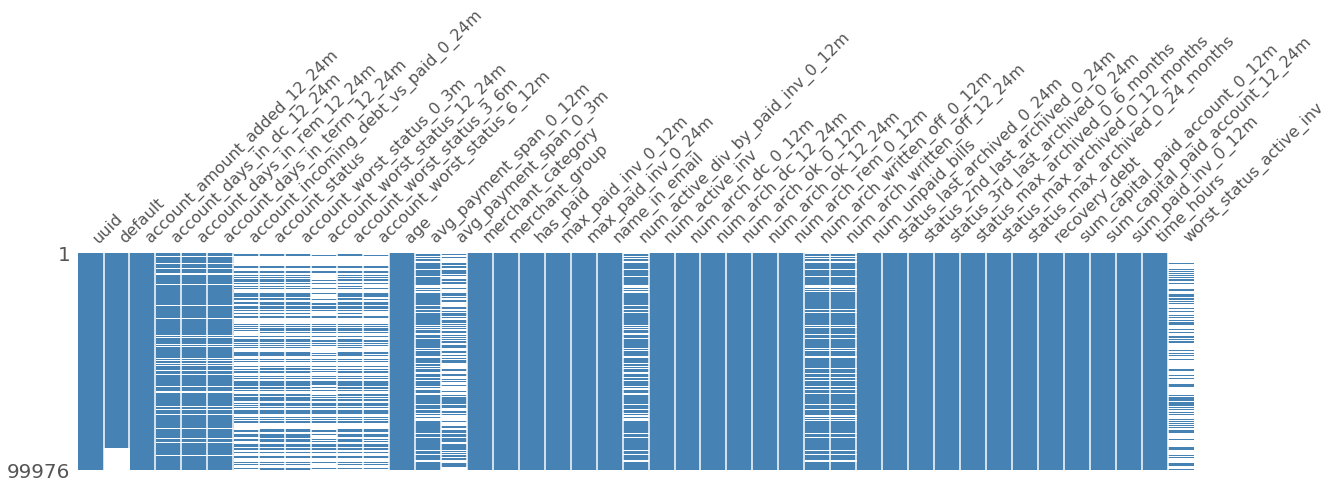

In [5]:
missingno.matrix(full_df, figsize=(20, 4), sparkline=False, color=(0.275, 0.51, 0.706))

At a quick glance, there's nothing special about the test set (rows where `default` is missing). The missing values appear to be similarly distributed as the training set.

Also, the presence of straight white lines across features (especially the `account_status` features) tells us that several features are either all present or all absent. This will have implications for predictions: Some datapoints have a lot of signal whereas other datapoints are very signal-sparse.

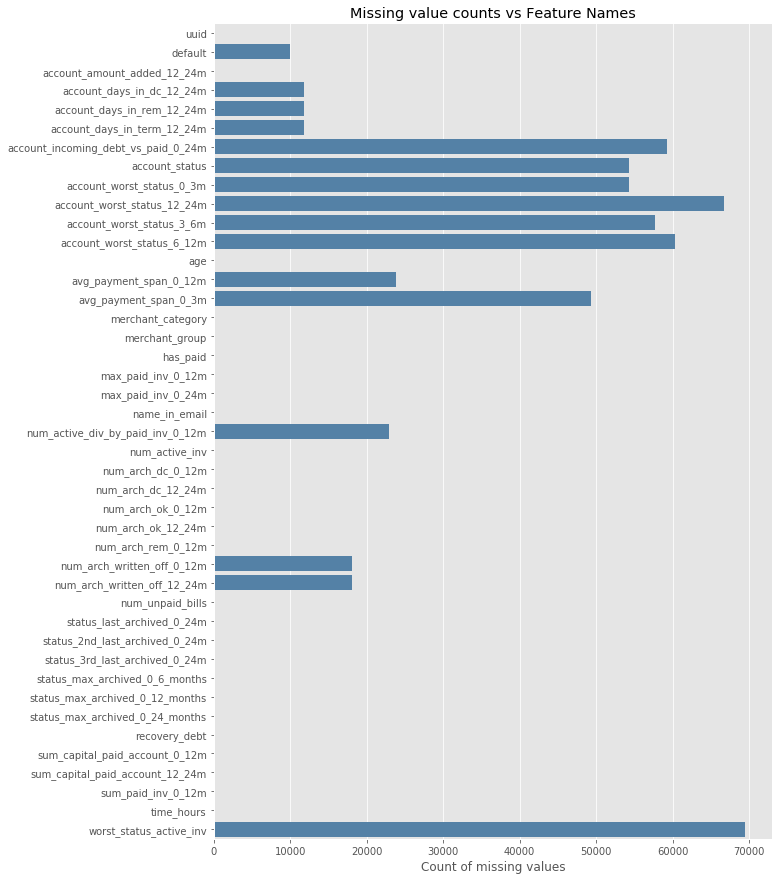

In [6]:
missing = full_df.isna().sum()
fig, ax = plt.subplots(figsize=(10, 15))
ax.set_xlabel("Count of missing values")
ax.set_title("Missing value counts vs Feature Names")
sns.barplot(x=missing.values, y=missing.index, ax=ax, color="steelblue")

There are plenty of missing values. There are some variables for whom a majority of the observations are missing. One option is to remove some such highly-unavailable feature from the model itself to decrease model complexity however since *'whether a value is missing or not'* can itself have preditive signal, I'm choosing to keep the missing values. Regularization  can then be used to deal with model complexity.

As a last step, let's check the correlation between missing values. Often, this can reveal hidden structures in the data gathering process.

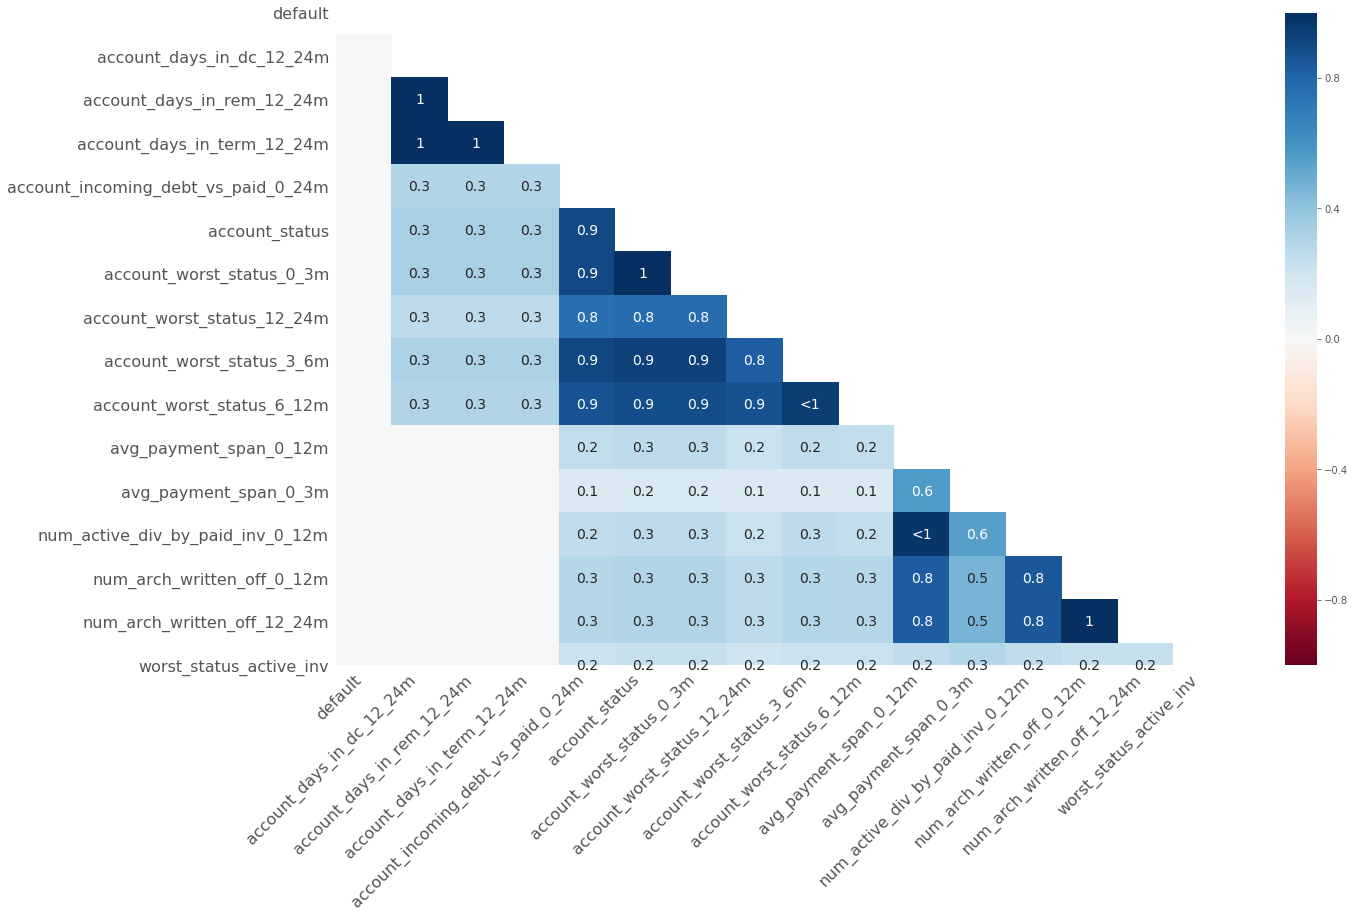

In [7]:
# Correlation in missing values
missingno.heatmap(full_df)

There exists a definite correlation structure among the missing values. Mostly, it appears that feature groups (such as `account_worst_status_X_Y`) are generally absent from the dataset together. This makes sense: if a `status` is missing in the last 12 months, it is also likely to be missing in the 12 month - 24 month period.

Beyond this however, it is not possible to make any inferences without knowing what these features mean and how they are collected.

## Univariate Analysis

Let's plot distributions of all features. This will help us spot any obvious problems with the data such as gaps in histograms, outliers, skewness, imbalance etc.

### Numeric Features

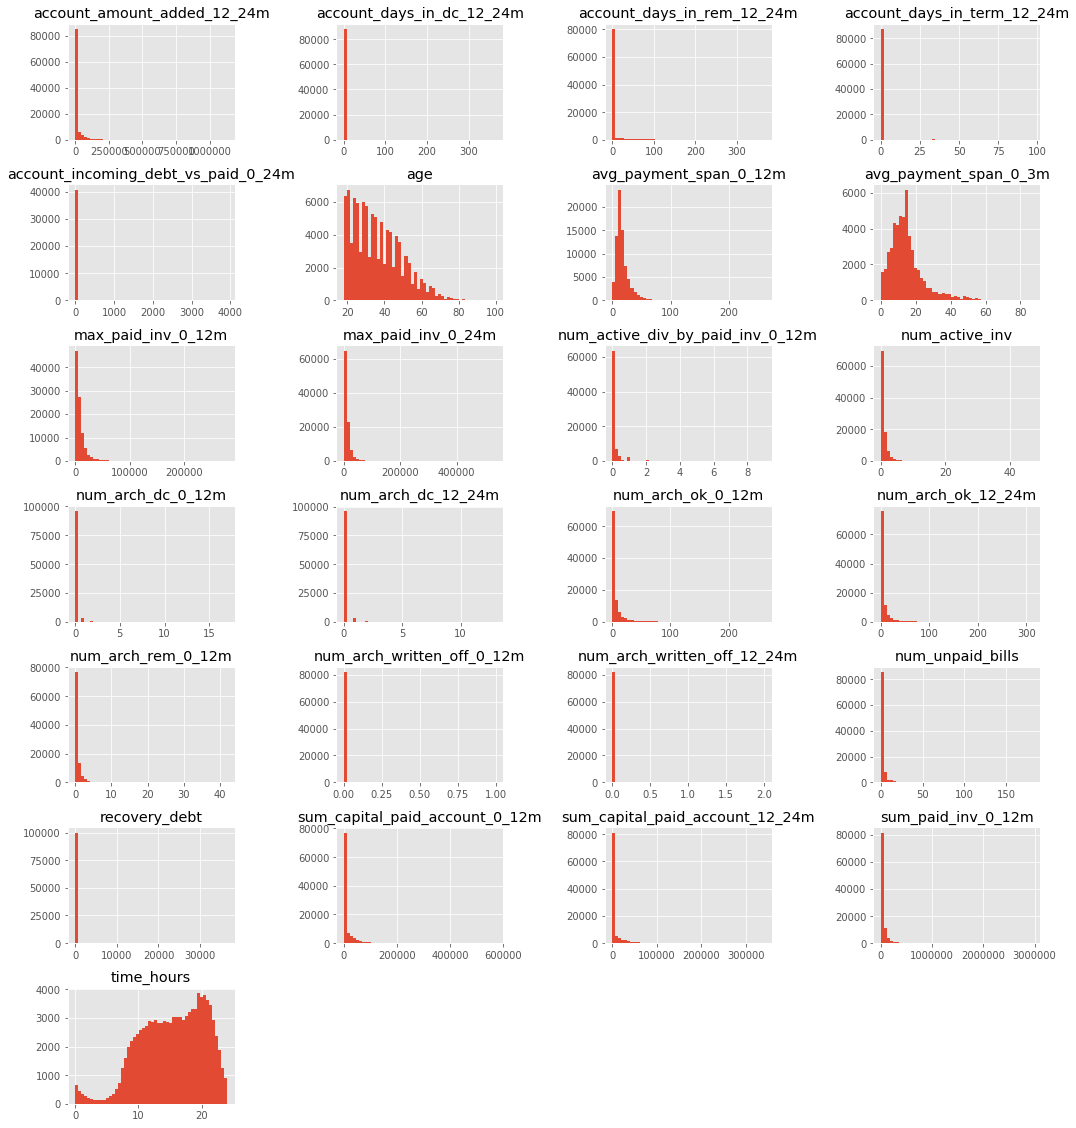

In [8]:
full_df[numeric_features].hist(figsize=(15, 20), layout=(9, 4), bins=50)
plt.tight_layout()

#### Observations

- Almost all numeric variables are highly right skewed. These features might need to be transformed if they are to be used in an algorithm sensitive to skewed distributions
- Could be indicative of outliers in the dataset for some of the features. However, without knowing what these features mean, it is not possible to remove outliers (e.g., `account_amount_added` might really be as high as 1,000,000 cents). This will need to be revisited later based on which algorithm is chosen for use.

### Categorical Features

First, let's plot all categorical features (inclugin NA values). This will give us a better idea of:
- How many categorical features we will end up with after e.g., one hot encoding
- How NA values compare to feature categories
- Show imbalance in categories

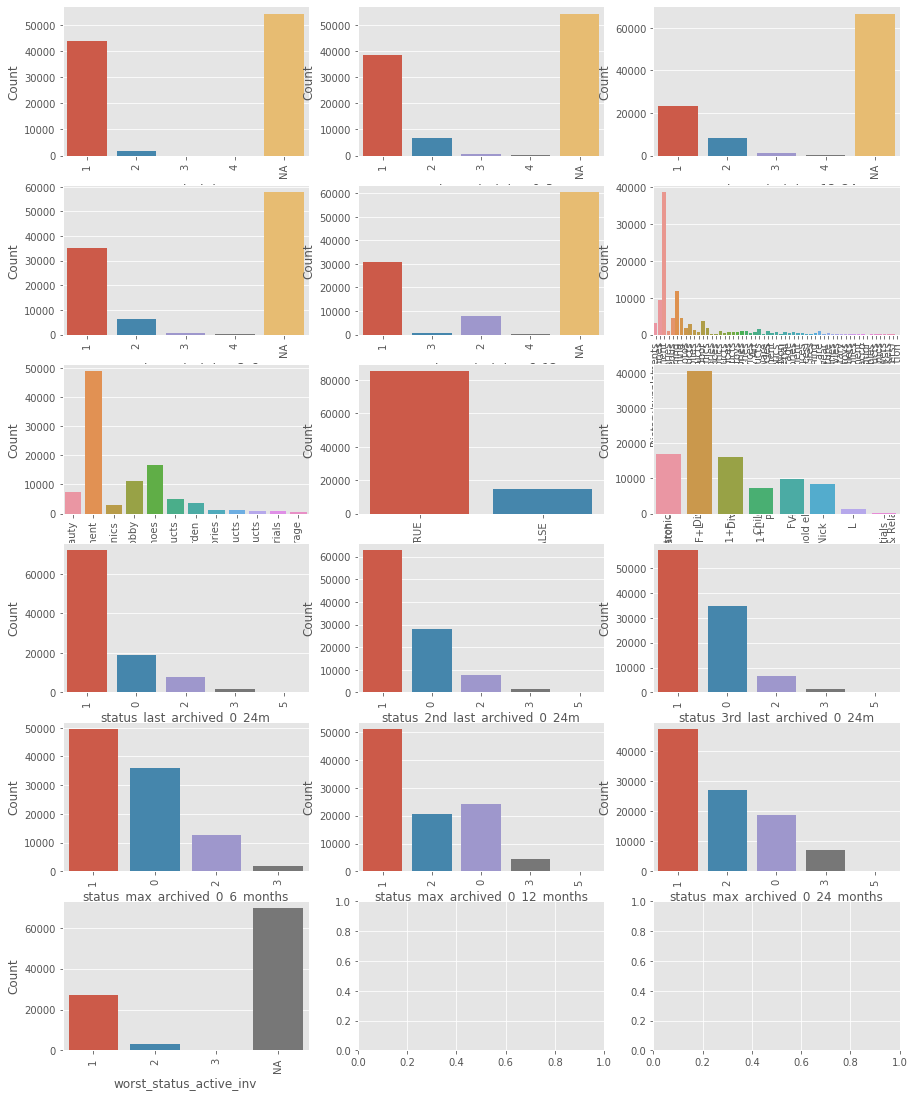

In [9]:
fig, ax = plt.subplots(6, 3, figsize=(15, 20))

for feature, subplot in zip(categorical_features, ax.flatten()):
    plot_order = full_df[feature].dropna().unique().tolist()
    plot_order = plot_order + ([] if full_df[feature].isna().sum() == 0 else ["NA"])
    sns.countplot(full_df[feature].fillna("NA"), ax=subplot, order=plot_order)
    subplot.set_ylabel("Count")
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

#### Observations

- For most features, the `NA` values are **not** the majority of values (this is important because if a feature is mostly NA and is also weakly correlated with the output, it might be possible to drop the feature altogether and simplify the model)
- `NA` values are dominant in `account_status`, `account_worst_status_X_Y` and `worst_status` columns. Let's make a note of these features and later it should be checked how weakly/strongly correlated these features are with the target variable
- The total number of unqiue categorical features (after one-hot encoding for e.g.) is quite reasonable considering the size of the dataset

### Target Variable Distribution
Let's check the percentage of positive (`default == 1`) and negative values for the target

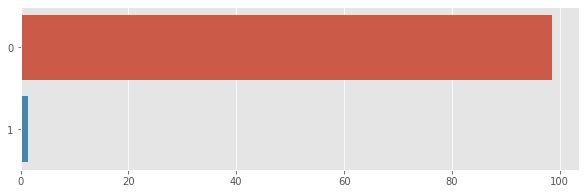

In [10]:
is_train = ~full_df["default"].isna()
freq_df = full_df[is_train].default.value_counts() * 100 / full_df[is_train].shape[0]
plt.figure(figsize=(10, 3))
sns.barplot(y=freq_df.index, x=freq_df.values, orient="h")

In [11]:
freq_df

0    98.568507
1     1.431493
Name: default, dtype: float64

So, for the target variable:
- Negative Labels: **~98.5%**
- Positive Labels: **~1.5%**

This is therefore a highly imbalanced dataset.

## Dealing with Imbalance

To deal with the imbalance, the following steps need to be taken:
- Unless the imbalance in the dataset is handled, the classifier will be highly biased and will almost always predict the negative class. For this, the classification algorithm needs to either:
    - Weigh positive cases high/weigh negative cases low so that the loss function finds a good optima
    - Or, postive cases can be oversampled/negative cases can be undersampled for the same effect
- The estimator's loss function should heavily penalizes misclassification
- A good model evaluation metric needs to be selected for evaluating model performance


### Choice of an algorithm

I am choosing to use [LightGBM](https://github.com/microsoft/LightGBM) for prediciting probability of `default==1`. The reasons for picking this algorithms are:
- LightGBM (and gradient boosting in general) has been shown to work well (both in terms of speed and predictive performance) for similar problems in the past
- LightGBM allows to set custom weights on training samples thus allowing to proportionally increase the misclassification loss for positive cases in the dataset. This is one of the stategies to deal with imbalanced dataset as discussed earlier
- LightGBM also learns quite quickly for large datasets which helps in quick iteration
- Being a tree based method, scaling the inputs is not necessary as monotonic transformation make little to no difference on tree based methods
- This algorithm is also robust to outliers which is useful as the numerical features are highly right skewed

### Choice of a loss-function

The loss-function needs to penalize misclassification heavily. Otherwise, the model could always predict probability of default close to zero and it would have very low/no loss 98.5% of the time. Therefore, the loss that the model accrues over the remaining 1.5% of the samples should be high enough to offset the no-loss from the other 98.5% negative cases.

For this scenario,`log-loss` (aka cross entropy loss) works well. It penalizes large misclassification errors exponentially more. It is also implemeted as the default loss function in `LightGBM` so there is no need to implement it separately.

### Choice of an evaluation metric

Choosing a good evaluation metric for the estimator is very important. Since the dataset is highly imbalanced, it obviously rules out `accuracy` as a metric. Now, for the given task, the probability of default for an account needs to be predicted. Therefore, let's make the following assumptions about the cost of misclassification:
**Assumptions**
- The cost of misclassifying default (i.e., model predicts `No Default` when the account actually defaults or the Type II error) is quite high (several hundred euro of direct loss and loss of trust from merchant)
- The cost of classifying a `No Default` account as `Default` (Type I error) is lower than cost of Type II error. However, the number of accounts with `No Default` is also approximately 100x than accounts with `Default`. Therefore, even a small loss due to a Type I error here may sum up to more overall loss.

Therefore, I'm using the following guidelines in deciding on an evaluation metric:
- It's preferable to have a really low Type II error -> increase `recall`
- A reasonably low Type I error is also needed -> increase `precision`


If the estimated dollar value of both of these errors was known, it would be straightforward to come up with the optimal balance point between `precision` and `reacll`. Since the dollar value of losses isn't known, an even balance between `precision` and `recall` is a good choice: we make sure that neither score gets too low.

**Based on this, the `f1-score` and `Area Under Precision-Recall Curve` will be used as measures of model performance.** Model `precision` and `recall` will also be moniotored to make sure that both scores are reasonable.

Model peformance can also be visualized with a Precision-Recall curve. This [kaggle notebook](https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve) is a good reference for evaluation metrics in highly imbalanced data.

## Bivariate analysis

Here, all variables vs the target variable are plotted. For numeric variables, boxplots are used and for categorical variables, barplots.

### Numeric features

Because of the high right skew in most features, **let us plot log of feature values**

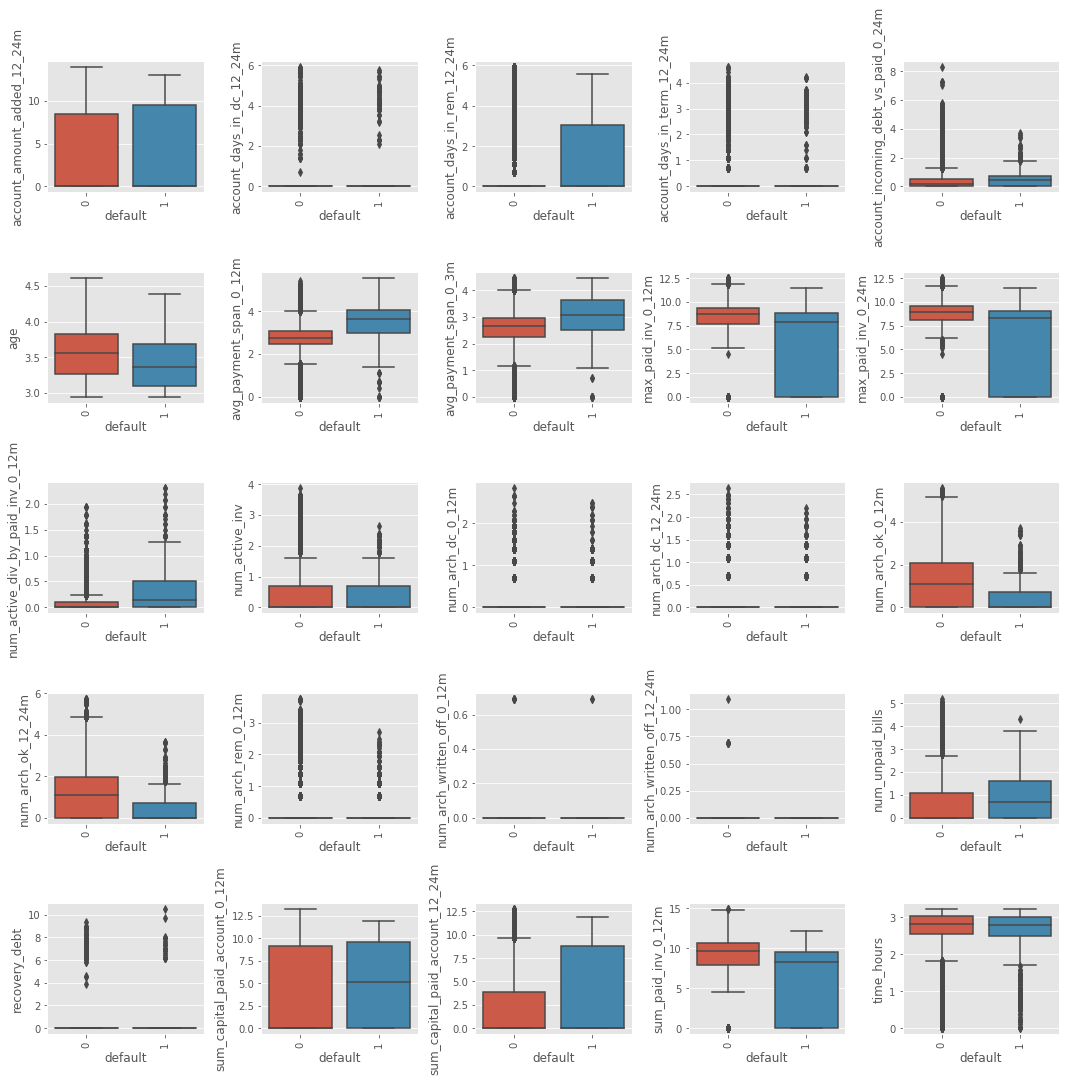

In [12]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
_df = full_df.loc[is_train, numeric_features].applymap(
    lambda x: np.log(x + 1) if not np.isnan(x) else np.nan
)
_df["default"] = full_df["default"]
for feature, subplot in zip(numeric_features, ax.flatten()):
    sns.boxplot(x="default", y=feature, data=_df, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()

#### Observations

Significant looking differences between distributions on defaulted vs non-defaulted accounts can clearly be seen. Some features that stand out:
- `account_days_in_rem_12_24m`
- `age`
- `avg_payment_span_X_Y`
- `num_unpaid_bills`
- `sum_paid_X_Y`

When looking at feature importance, it should be checed whether these features show high predictive power. Also, there are quite a few outlier values, even with a log-value plot. But since Tree based method is being used, these values do not need to be removed/adjusted.

## Categorical features

Let's plot barcharts of counts of all feature values vs `default`

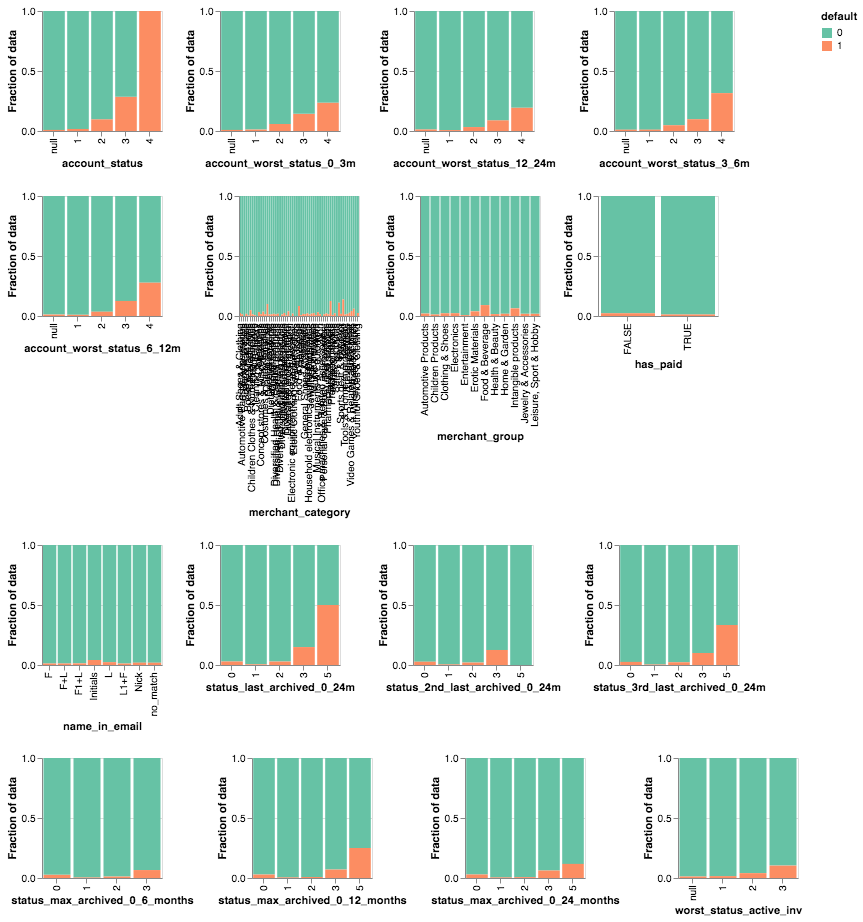

In [13]:
base = (
    alt.Chart()
    .mark_bar()
    .encode(
        alt.Y("count():Q", stack="normalize", title="Fraction of data"),
        alt.Color("default:N", scale=alt.Scale(scheme="set2")),
    )
    .properties(width=120, height=120)
)

chart = alt.vconcat(data=full_df[is_train])
for row_idx in range(4):
    row = alt.hconcat()
    for col_idx in range(4):
        idx = 4 * row_idx + col_idx
        if idx >= len(categorical_features):
            break
        feature = categorical_features[idx]
        row |= base.encode(x=alt.X(feature, type="nominal"))
    chart &= row

chart

#### Observations

Again, there are clear patterns in the number of deafults within features values. For example:
- `account_status` and `account_worst_status_X_Y` all have increasing percentage of defaults as we go from status `1` to `4`
- `status_<type>_archived_X_Y` also has shows a U-shaped pattern in percentage of defaults

##### Target vs Null values

In the `account_status` and `account_worst_status_X_Y` features, there is almost no `default` when these features are missing. This suggests the following feature engineering strategy:
- For each feature with `NaN` values, add a `is_feature_null` column to explicitly capture this signal

# Modeling

## Baseline Estimator

As our baseline, scikit-learn's `RandomForestClassifier` with `class_weight="balanced` is used. This model is chosen as the baseline because of its ease of use and becuase it can produce good results without much tuning needed.

In [14]:
X = full_df.drop(columns=["default", "uuid"])
y = full_df.default

In [15]:
ohe = OneHotEncoder()

# fit OHE on all data so that we don't miss any features
ohe.fit(X[categorical_features].fillna("MISSING_DATA"))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [16]:
X_train = hstack(
    [
        X.loc[is_train, numeric_features].fillna(-9999),
        ohe.transform(X.loc[is_train, categorical_features].fillna("MISSING_DATA")),
    ]
)
y_train = y[is_train].astype("int32")

In [17]:
clf = RandomForestClassifier(class_weight="balanced")

In [18]:
# Out-of-fold prediction on full training set
y_pred = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=4)
y_pred_proba = cross_val_predict(
    clf, X_train, y_train, cv=5, n_jobs=4, method="predict_proba"
)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     88688
           1       0.62      0.06      0.11      1288

    accuracy                           0.99     89976
   macro avg       0.81      0.53      0.55     89976
weighted avg       0.98      0.99      0.98     89976

Precision-Recall AUC=0.170


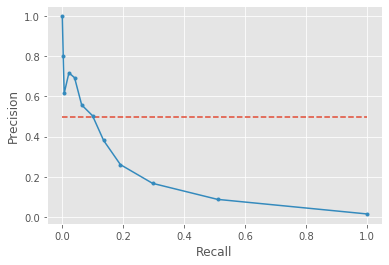

In [19]:
print(classification_report(y_train, y_pred))
get_prec_recall_auc(y_train, y_pred_proba[:, 1])

### Observations about baseline estimator

The F1-Score and Recall of the `RandomForestClassier` model are quite poor. Even though total number of misclassified `default` samples is quite small (as evidenced by the `0.98` weighted F1-Score), for the purpose of predicting probability of default, this model does very poorly.

## LightGBM Model

Let's now make a `LightGBM` model and try to improve it incrementally.

### Strategy

- To start off, a simple LightGBM model with deafult parameters and `class_weight="balanced"` will be used and compared to baseline.
- As LightGBM can handle missing values on its own (it splits on features by ignoring missing values and then puts all missing values in the node which results in higher gain), the following methods of handling `NaN` values will be tried:
    - Encode missing value with a `MISSING_DATA` token for categorical features and `-9999` for numeric features.
    - Leave `NaN` values in the data and allow LightGBM to handle it
- Feature engineering: Add `is_feature_null` category (although this probably won't make much of a difference if missing values are encoded; this will work much better if the `NaN` values are left in the training data for LightGBM to handle natively)
- For tuning model complexity, `num_leaves`, `num_estimators`, regularization parameters and sampling parameters (fraction of features/fraction of training data to consider for a split) can be experimented with.

### Model 1: LightGBM with default parameters and encoded missing values

In [20]:
# OrderEncoder is used because LightGBM can handle categorical data natively
# but, the categories need to be integer encoded
ord_enc = OrdinalEncoder(dtype=np.int32)
ord_enc.fit(X[categorical_features].fillna("MISSING_DATA"))
Xt_num = X.loc[is_train, numeric_features].fillna(-9999)
Xt_cat = pd.DataFrame(
    ord_enc.transform(X.loc[is_train, categorical_features].fillna("MISSING_DATA")),
    columns=categorical_features,
)

X_train = pd.concat([Xt_num, Xt_cat], axis=1)
y_train = y[is_train].astype("int32")
clf = LGBMClassifier(is_unbalance=True)
fit_params = {"categorical_feature": categorical_features, "verbose": 3}

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     88688
           1       0.08      0.62      0.15      1288

    accuracy                           0.90     89976
   macro avg       0.54      0.76      0.55     89976
weighted avg       0.98      0.90      0.93     89976

Precision-Recall AUC=0.155


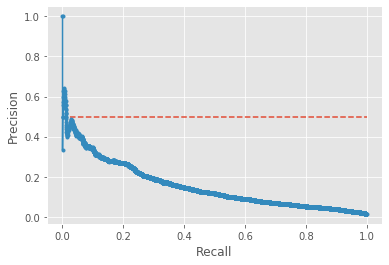

In [21]:
y_pred_proba = cross_val_predict(
    clf, X_train, y_train, cv=5, n_jobs=4, method="predict_proba", fit_params=fit_params
)
y_pred = y_pred_proba[:, 1] > 0.5
print(classification_report(y_train, y_pred))
get_prec_recall_auc(y_train, y_pred_proba[:, 1])

#### Observations for Model 1

The recall score saw a drastic increase (0.65) at the cost of precision. It appears that the classifier is overfitting on the `default==1` cases. Ideally, there should be a better balance between precision and recall. For this, sample weight of both classes can be manually calibrated.

**F1-Score: 0.10 -> 0.15**

**Recall: 0.06 -> 0.62** 

**PR Curve AUC: 0.175 -> 0.155**

### Model 1.1: LightGBM with default parameters and manually set sample weights

In the last model, it was found that using`is_unbalace=True` sets sample weights such that the model overemphasizes `default==1` in the prediction results. This let the model have great `recall` but the model precision was completely ruined.

Now, to find a better balance between precision and recall, a range of weights for `default==1` samples are used are precision/recall/f1-score are all monitored.

In [22]:
positive_sample_weight = [1, 2, 5, 10, 15, 20, 30, 50, 75, 100]
results = {}
for wt in positive_sample_weight:
    clf = LGBMClassifier(scale_pos_weight=wt)
    fit_params = {"categorical_feature": categorical_features, "verbose": 3}
    y_pred_proba = cross_val_predict(
        clf,
        X_train,
        y_train,
        cv=5,
        n_jobs=4,
        method="predict_proba",
        fit_params=fit_params,
    )
    y_pred = y_pred_proba[:, 1] > 0.5
    results[str(wt)] = [y_pred, y_pred_proba]

In [23]:
# Plot precision, recall and f1_score vs positive sample weight
scores = [precision_recall_fscore_support(y_train, results[wt][0]) for wt in results]
scores_df = pd.DataFrame(columns=["precision", "recall", "f1_score"])
for idx, sc in enumerate(scores):
    scores_df.loc[idx] = [sc[0][1], sc[1][1], sc[2][1]]

scores_df["weight"] = positive_sample_weight
scores_df.set_index("weight", inplace=True)

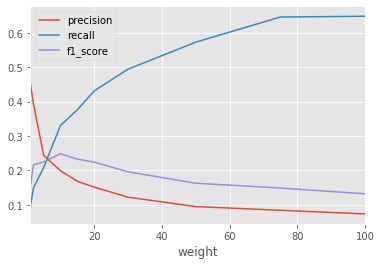

In [24]:
scores_df.plot.line()

Therefore, the best F1-score and a good balance between precision and recall takes place around `scale_pos_weight=5`. Furthur tuning reveals the crossover point to be at `scale_pos_weight=5.7`. This value will be used going forward.

**Note**: This weight can obviously be tuned to be better in line with business goals. A higher weight could have been chosen to get better recall at the cost of precision.

Retraining **Model 1** with the correct weight (not shown here), the results are:

**F1-Score: 0.155 -> 0.25**

**Recall: 0.62 -> 0.24** 

**PR Curve AUC: 0.155 -> 0.173**

Now, with a better balanced weight, the model emphasizes both precision and recall equally. This made the model recall drop but model precision improved.

In [25]:
POS_WT = 5.7

### Model 2: LightGBM with default parameters and training with missing values in dataset

In [26]:
# Since OrdinalEncoder doesn't hadnle NaN natively, get a mask of all NaNs
# Then, re-set values to NaN after the transformation
is_na_mask = X.loc[is_train, numeric_features + categorical_features].isna()

ord_enc = OrdinalEncoder(dtype=np.int32)
ord_enc.fit(X[categorical_features].fillna("MISSING_DATA"))

Xt_num = X.loc[is_train, numeric_features]
Xt_cat = pd.DataFrame(
    ord_enc.transform(X.loc[is_train, categorical_features].fillna("MISSING_DATA")),
    columns=categorical_features,
)
X_train = pd.concat([Xt_num, Xt_cat], axis=1)

# set values back to NA
X_train[is_na_mask] = np.nan
y_train = y[is_train].astype("int32")

clf = LGBMClassifier(scale_pos_weight=POS_WT)
fit_params = {"categorical_feature": categorical_features, "verbose": 3}

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     88688
           1       0.25      0.25      0.25      1288

    accuracy                           0.98     89976
   macro avg       0.62      0.62      0.62     89976
weighted avg       0.98      0.98      0.98     89976

Precision-Recall AUC=0.169


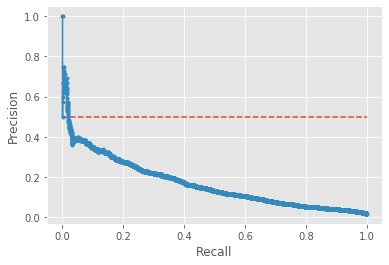

In [27]:
y_pred_proba = cross_val_predict(
    clf, X_train, y_train, cv=5, n_jobs=4, method="predict_proba", fit_params=fit_params
)
y_pred = y_pred_proba[:, 1] > 0.5
print(classification_report(y_train, y_pred))
get_prec_recall_auc(y_train, y_pred_proba[:, 1])

#### Observations for Model 2

With missing values not encoded in the data, it is seen that racall and f1-score remain basically unchanged but PRAUC goes down. So it's better to stick with encoding missing values.

**F1-Score: 0.25 -> 0.25**

**Recall: 0.25 -> 0.25** 

**PR Curve AUC: 0.173 -> 0.169**

### Model 3: Feature Engineering some isNull features

Let's do simple feature engineering by adding `is_feature_na` columns for missing features. Since encoded missing values are  being used, it is unlikely that these features will make much of a difference

In [28]:
# First make a dataframe with isna() results on training set
cols_with_na = X.columns[X[is_train].isna().any()].tolist()
Xt_isna = X.loc[is_train, cols_with_na].isna().astype("int32")
Xt_isna.columns = [f"isna_{col}" for col in cols_with_na]

ord_enc = OrdinalEncoder(dtype=np.int32)
ord_enc.fit(X[categorical_features].fillna("MISSING_DATA"))
Xt_num = X.loc[is_train, numeric_features].fillna(-9999)
Xt_cat = pd.DataFrame(
    ord_enc.transform(X.loc[is_train, categorical_features].fillna("MISSING_DATA")),
    columns=categorical_features,
)

X_train = pd.concat([Xt_num, Xt_cat, Xt_isna], axis=1)
y_train = y[is_train].astype("int32")
clf = LGBMClassifier(scale_pos_weight=POS_WT)
fit_params = {
    "categorical_feature": categorical_features + Xt_isna.columns.tolist(),
    "verbose": 3,
}

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     88688
           1       0.24      0.24      0.24      1288

    accuracy                           0.98     89976
   macro avg       0.62      0.61      0.61     89976
weighted avg       0.98      0.98      0.98     89976

Precision-Recall AUC=0.170


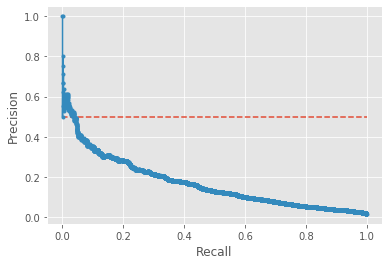

In [29]:
y_pred_proba = cross_val_predict(
    clf, X_train, y_train, cv=5, n_jobs=4, method="predict_proba", fit_params=fit_params
)
y_pred = y_pred_proba[:, 1] > 0.5
print(classification_report(y_train, y_pred))
get_prec_recall_auc(y_train, y_pred_proba[:, 1])

#### Observations about Model 3

After adding these extra features, model `recall`, `precision`, `f1-score` and `PRAUC` all went down  slightly. It could be that there are too many features for the model complexity. In any case, these features will not be used for the next step.

### Model 4: Tuning model complexity

For this, let's perform a hyper-paramter search using the following parameters:
- `num_leaves`
- `subsample`
- `colsample_bytree`
- `reg_alpha`
- `reg_lambda`

The library `scikit-optimize` is used (which uses [Bayesian Optimzation](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html)) to get to a first good set of parameters quickly.

This is done in three steps. To start, a wide space of parameters is used. Then, succesive parameter searches are used to zoom in on a good combination of parameters.

In [30]:
# commented out because this code takes a long time to run
"""
!pip install git+git://github.com/YannDubs/scikit-optimize.git@d8a5aefe7d472b7c7b929ef9135d71a263af7717#egg=scikit_optimize
X_train = pd.concat([Xt_num, Xt_cat], axis=1)
y_train = y[is_train].astype("int32")
fit_params = {"categorical_feature": categorical_features, "verbose": 3}

# set n_estimators to a very large value.
# tree numbers are actually controlled by early stopping. 5000 is the absolute maximum number
clf = LGBMClassifier(n_jobs=2, n_estimators=5000, scale_pos_weight=POS_WT)

opt = BayesSearchCV(
    clf,
    {
        "num_leaves": (10, 200),
        "subsample": (0.75, 1, "uniform"),
        "colsample_bytree": (0.75, 1, "uniform"),
        "reg_alpha": [0, 0.1, 1],
        "reg_lambda": [0, 0.1, 1],
    },
    scoring="f1",
    n_jobs=2,
    n_points=2,
    n_iter=100,
    cv=4,
    verbose=False,
    return_train_score=True,
)

# Use X_train and y_train from last model
opt.fit(X_train, y_train)
"""

BayesSearchCV(cv=4, error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=5000,
                                       n_jobs=2, num_leaves=31, objective=None,
                                       random_state=None, reg_alpha=0.0,
                                       reg_lambda=0.0, scale...
                                       subsample_freq=0),
              fit_params=None, iid=True, n_iter=100, n_jobs=2, n_points=2,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=True

In [31]:
# opt.best_score_

0.22940359212578645

In [33]:
# opt.best_params_

{'colsample_bytree': 0.75,
 'num_leaves': 160,
 'reg_alpha': 1,
 'reg_lambda': 0,
 'subsample': 0.75}

After a few more rounds of running the `BayesianSearchCV` (no shown here for brevity and because it takes a while to run) by subsequently *zooming in* on a good set of parameters, the following parameters are obtained:
- `colsample_bytree`=0.5
- `num_leaves`=15
- `reg_alpha`=1
- `reg_lambda`=1
- `subsample`=0.85

This gives us the following results

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     88688
           1       0.28      0.27      0.27      1288

    accuracy                           0.98     89976
   macro avg       0.63      0.63      0.63     89976
weighted avg       0.98      0.98      0.98     89976

Precision-Recall AUC=0.193


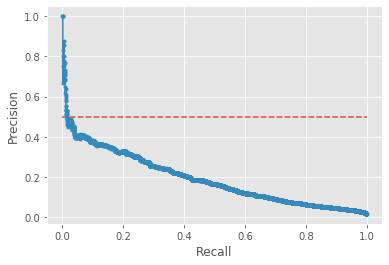

In [34]:
clf = LGBMClassifier(
    colsample_bytree=0.5,
    num_leaves=15,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.85,
    scale_pos_weight=POS_WT,
)

y_pred_proba = cross_val_predict(
    clf, X_train, y_train, cv=5, n_jobs=4, method="predict_proba", fit_params=fit_params
)
y_pred = y_pred_proba[:, 1] > 0.5
print(classification_report(y_train, y_pred))
get_prec_recall_auc(y_train, y_pred_proba[:, 1])

This is a better result than Model 3 by 2 percentage points. It may be probably get a better result by tuning on some more parameters.

Now, the model learning will be tuned as often, better results can be obtained by using a lower learning rate coupled with a longer training time. This allows us to find a better minimum.

In [35]:
param_test = {"learning_rate": [0.01, 0.05, 0.1]}

clf = LGBMClassifier(
    n_estimators=5000,
    colsample_bytree=0.5,
    num_leaves=15,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.85,
    scale_pos_weight=POS_WT,
)

grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_test,
    scoring="f1",
    cv=4,
    verbose=False,
    return_train_score=True,
    n_jobs=-1,
)

grid_search_clf.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.5,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=5000,
                                      n_jobs=-1, num_leaves=15, objective=None,
                                      random_state=None, reg_alpha=1,
                                      reg_lambda=1, scale_pos_weight=5.7,
                                      silent=True, subsample=0.85,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'le

In [36]:
grid_search_clf.cv_results_

{'mean_fit_time': array([58.18710726, 62.41913557, 48.2695632 ]),
 'std_fit_time': array([0.40701416, 0.2984186 , 0.33315633]),
 'mean_score_time': array([19.50699109, 18.10953152, 10.51020104]),
 'std_score_time': array([0.26775031, 0.17721372, 0.64245379]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.05},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.28      , 0.28070175, 0.27494457]),
 'split1_test_score': array([0.25      , 0.17411765, 0.1797235 ]),
 'split2_test_score': array([0.26559356, 0.22222222, 0.22222222]),
 'split3_test_score': array([0.25984252, 0.22522523, 0.22421525]),
 'mean_test_score': array([0.26385902, 0.22556671, 0.22527638]),
 'std_test_score': array([0.01085984, 0.03774315, 0.03373591]),
 'rank_test_score': array([1, 2, 3], dtype=int32),
 'split0_train_score': array([0.81823114, 0.98

Looking at the 5-split test score, it can be see that the score goes up for training set and goes down for test set as we increase the learning rate. Also, the score is better for a smaller learning rate.

Therefore, it can be conculded that the earlier parameter minima with the default learning rate (0.1) was indeed not the best minima. A small learning rate (0.01) is now used to decide on exactly how many trees the model needs until it starts to overfit.

In [37]:
param_test = {"n_estimators": [100, 500, 1000, 5000, 10000]}

clf = LGBMClassifier(
    silent=False,
    learning_rate=0.01,
    colsample_bytree=0.5,
    num_leaves=15,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.85,
    scale_pos_weight=POS_WT,
)

grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_test,
    scoring="f1",
    cv=4,
    verbose=0,
    return_train_score=True,
    n_jobs=-1,
)

grid_search_clf.fit(X_train, y_train, **fit_params)

In [38]:
grid_search_clf.cv_results_

{'mean_fit_time': array([  2.22891659,   8.58703649,  15.19049501,  67.19638169,
        125.11318856]),
 'std_fit_time': array([0.05493549, 0.027429  , 0.08071617, 0.70359652, 0.61025384]),
 'mean_score_time': array([ 0.31064242,  1.39218426,  3.07999402, 19.88133526, 38.4019438 ]),
 'std_score_time': array([0.009713  , 0.02559521, 0.15348708, 0.32597296, 0.66918579]),
 'param_n_estimators': masked_array(data=[100, 500, 1000, 5000, 10000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 100},
  {'n_estimators': 500},
  {'n_estimators': 1000},
  {'n_estimators': 5000},
  {'n_estimators': 10000}],
 'split0_test_score': array([0.00619195, 0.27972028, 0.28919861, 0.28      , 0.2788671 ]),
 'split1_test_score': array([0.01846154, 0.23826715, 0.25945946, 0.25      , 0.20915033]),
 'split2_test_score': array([0.01234568, 0.26600985, 0.28711256, 0.26559356, 0.25596529]),
 'split3_test_score': array([0.006

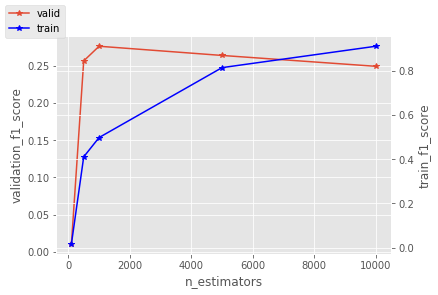

In [39]:
fig, ax = plt.subplots()
ax.plot(
    grid_search_clf.param_grid["n_estimators"],
    grid_search_clf.cv_results_["mean_test_score"],
    marker="*",
)
ax.set_xlabel("n_estimators")
ax.set_ylabel("validation_f1_score")

ax1 = ax.twinx()
ax1.plot(
    grid_search_clf.param_grid["n_estimators"],
    grid_search_clf.cv_results_["mean_train_score"],
    marker="*",
    color="blue",
)
ax1.set_ylabel("train_f1_score")

fig.legend(["valid", "train"], loc="upper left")

#### Observations for Model 4: After parameter tuning

With a lower learning rate and high number of boosting rounds and a better set of parameter, the estimator performance increased by a few percentage points. Therefore, the changes to make from the parameter tuning step are as follows:
- `colsample_bytree`: 1.0 -> 0.5
- `num_leaves`: 31 -> 15,
- `reg_alpha`: 0 -> 1,
- `reg_lambda`: 0 -> 1,
- `subsample`: 1.0 -> 0.85,
- `n_estimators`: 100 -> 1000
- `learning_rate`: 0.1 -> 0.01

These changes, in aggregate, have a mostly regularizing/complexity decreasing effect on the moodel. Therefore, it can be concluded that the classifier with default parameters was likely to be overfitting to the trainig set.

Also, after the number of estimators was increased to 10x and the learning rate was reduced to 1/10x, there was again some improvement in the model performance which suggests that the learning rate was too high and that model training was missing the minimum.

## Final Model

Let's take all the parameter improvements and train a final model on the entire dataset. Also, the `POS_WT` parameter was increased to 6 because it gives better results with the tuned parameters.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     88688
           1       0.30      0.27      0.28      1288

    accuracy                           0.98     89976
   macro avg       0.64      0.63      0.64     89976
weighted avg       0.98      0.98      0.98     89976

Precision-Recall AUC=0.216


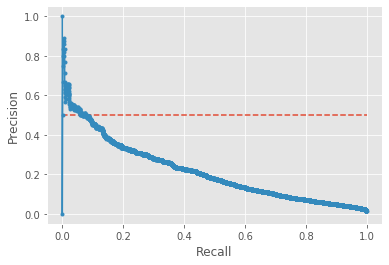

In [40]:
X_train = pd.concat([Xt_num, Xt_cat], axis=1)
y_train = y[is_train].astype("int32")
fit_params = {"categorical_feature": categorical_features, "verbose": 3}
POS_WT = 6

clf = LGBMClassifier(
    colsample_bytree=0.5,
    num_leaves=15,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.85,
    scale_pos_weight=POS_WT,
    learning_rate=0.01,
    n_estimators=1000,
)

y_pred_proba = cross_val_predict(
    clf, X_train, y_train, cv=5, n_jobs=4, method="predict_proba", fit_params=fit_params
)
y_pred = y_pred_proba[:, 1] > 0.5
print(classification_report(y_train, y_pred))
get_prec_recall_auc(y_train, y_pred_proba[:, 1])

#### Observations for the Final Model

With the tuning, the model gains a few percentage points of performance. The tuned model has the following performace score updates:

**F1-Score: 0.25 -> 0.28**

**Recall: 0.25 -> 0.27** 

**Precision: 0.25 -> 0.30**

**PR Curve AUC: 0.17 -> 0.216**


# Generate Final Predictions

For this, let's train on the full dataset.

In [41]:
ord_enc = OrdinalEncoder(dtype=np.int32)
ord_enc.fit(X[categorical_features].fillna("MISSING_DATA"))

Xfull_num = X.loc[:, numeric_features].fillna(-9999)
Xfull_cat = pd.DataFrame(
    ord_enc.transform(X.loc[:, categorical_features].fillna("MISSING_DATA")),
    columns=categorical_features,
)
Xfull = pd.concat([Xfull_num, Xfull_cat], axis=1)
X_train = Xfull[is_train]
X_test = Xfull[~is_train]

y_train = y[is_train].astype("int32")
POS_WT = 6

clf = LGBMClassifier(
    colsample_bytree=0.5,
    num_leaves=15,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.85,
    scale_pos_weight=POS_WT,
    learning_rate=0.01,
    n_estimators=1000,
)
clf.fit(X_train, y_train, categorical_feature=categorical_features)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=15, objective=None,
               random_state=None, reg_alpha=1, reg_lambda=1, scale_pos_weight=6,
               silent=True, subsample=0.85, subsample_for_bin=200000,
               subsample_freq=0)

In [42]:
y_pred_proba = clf.predict_proba(X_test)

pred_df = pd.DataFrame(
    {
        "uuid": full_df.loc[~is_train, "uuid"].tolist(),
        "pd": np.around(y_pred_proba[:, 1], decimals=4),
    }
)

In [44]:
pred_df.to_csv("../../predictions.csv", index=False, sep=";")

# Feature Importance

Now, let's look at feature importance scores to know which are the most important features and which (if any) features can be dropped to reduce model complexity without affecting performance.

In [46]:
clf.feature_importances_

array([ 467,  132,  460,  108,  611,  904,  760,  431,  536,  632,  218,
        188,  164,  235,  327,  425,  155,   14,    5,  507,  152,  647,
        284,  655,  813,  190,  286,  115,  240,  246, 1551,  233,   18,
        374,  137,  192,   55,  156,   36,  152,  189])

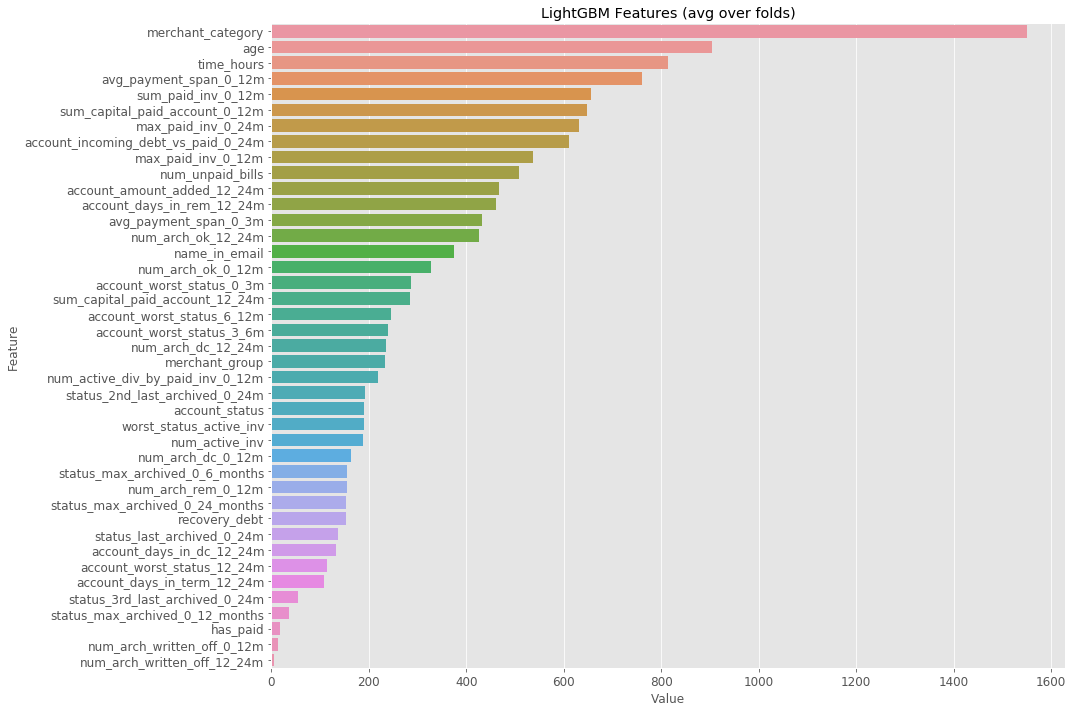

In [73]:
feature_imp = pd.DataFrame(
    sorted(zip(clf.feature_importances_, X_train.columns), reverse=True),
    columns=["Value", "Feature"],
)
plt.figure(figsize=(15, 10))
ax = sns.barplot(x="Value", y="Feature", data=feature_imp)
ax.tick_params(axis="both", which="major", labelsize=12)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()

### Observations from feature importance

What stands out is that merchant category has such an outsized impact on the prediction. Looking back at the bivariate analysis charts, it can be seen that there are clear patterns in fraction of defaulting accounts among merchant categories. This coupled with the high granularity of merchant categories likely allows the model to find better splits.

Also, all variations of amount paid are also high on the feature importance list which agrees with the observations made in bivariate analysis earlier.

**Using feature importance for model/process improvement**
Feature importance tells us which features to focus on when collecting data and also which features can be ignored/de-prioritized. Similarly, feature importance can be used to simplify the prediction model which has the benefit for making training/parameter-tuning and prediction faster and making the model more interpretable.

## Further possible improvements

### Improvements for dealing with imbalance

For dealing with imbalanced classes, the *class-weight method* was used where samples belonging to the less-common category were given a higher weight. This has the effect of weighing training loss such that misclassifying the infrequent category results in a much larger loss. Therefore, the trained model was more balanced in its predictions. 

The other way to handle imbalance is to change the distribution of the training set. This can be done by either:
- Undersampling the over-represented class
- Oversampling the under-represented class
- Combination of both

Undersampling should only be used if with a large amount of data as effectively, some useful data gets thrown away. Oversampling is done using algorithms such as [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) and [ADASYN](https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf). These are both synthetic sampling methods which generate new samples using KNN of existing samples and adding some random noise (in case of ADASYN).


### Improvements in algorithm

LightGBM is a general purpose gradient boosting algorithm which works well for most classification tasks. However, there are several algorithms that are more appropriate for detecting infrequent positive samples in an unbalanced dataset. One such algorithm is [Isolation Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) which is a modification on random forests and treats the problem of finding positive samples as an anomaly detection problem. It works on the premise that "Happy families are all alike; every unhappy family is unhappy in its own way". Isolation forest try to find samples where the splits end up in leaves very quickly compared to other non-outlier samples. Islocation forests might work well for this usecase if there are clear outliers in the features/combination of features for all `default` cases.
